# Wazobia Real Estate Prices Prediction.

In [1]:
! pip install catboost --quiet
! pip install shap --quiet
! pip install xgboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.0 MB/s eta 0:00:00


In [32]:
#import all packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import shap

from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
plt.style.use('fivethirtyeight')

%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
#loading data
train = pd.read_csv('Housing_dataset_train.csv')
test = pd.read_csv('Housing_dataset_test.csv')
subm = pd.read_csv('Sample_submission.csv')

In [4]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,14000.0,4.862700e+03,3.818348e+03,0.00,1.672750e+03,3.527000e+03,8011.250,12999.00
bedroom,12201.0,4.308171e+00,2.441165e+00,1.00,2.000000e+00,4.000000e+00,6.000,9.00
bathroom,12195.0,3.134235e+00,2.035950e+00,1.00,1.000000e+00,2.000000e+00,5.000,7.00
parking_space,12189.0,3.169825e+00,1.599415e+00,1.00,2.000000e+00,3.000000e+00,4.000,6.00
price,14000.0,2.138082e+06,1.083057e+06,431967.29,1.393990e+06,1.895223e+06,2586699.494,16568486.16


In [ ]:
#Summary statistics for categorical columns
train.describe(include=[object]).T

,count,unique,top,freq
loc,12187,36,Kaduna,370
title,12278,10,Flat,1372


In [104]:
train.shape

(14000, 7)

In [105]:
test.shape

(6000, 6)

In [ ]:
#check for duplicate data
duplicate = train.duplicated()
print(duplicate.sum())

0


## Exploratory Data Analysis

In [5]:
#Checking the list of column names avaiable in the dataset
train.columns

Index(['ID', 'loc', 'title', 'bedroom', 'bathroom', 'parking_space', 'price'], dtype='object')

### Univariate Analysis

In [33]:
def countplot(col_name):
  train[col_name].value_counts().plot(kind = "bar", title = f'Building {col_name}', figsize=(10, 5))
  plt.xticks(rotation = 90)
  plt.show()

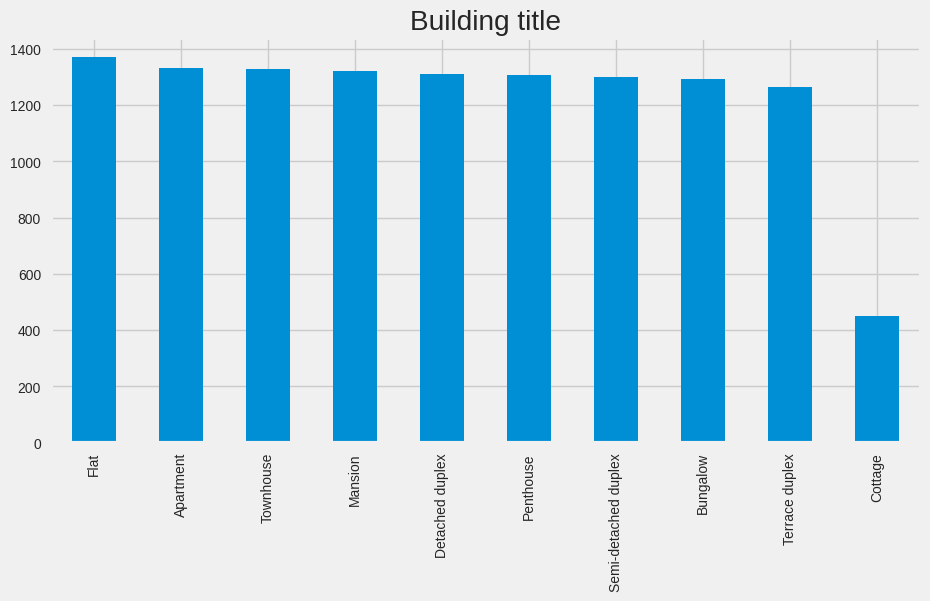

In [34]:
countplot('title')

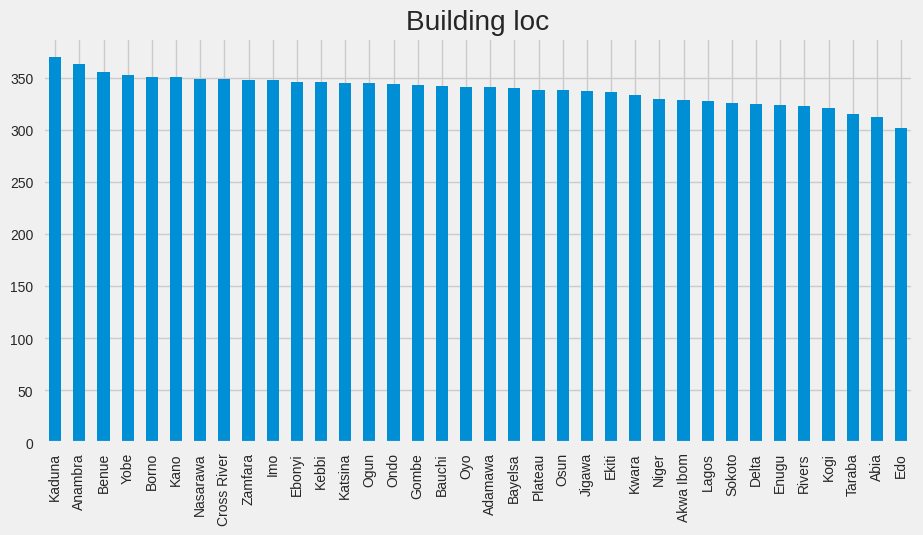

In [35]:
countplot('loc')

In [36]:
def countplot(col_name):
  train[col_name].value_counts().plot(kind = "bar", title = f'No of {col_name} in the building', color = 'coral', figsize=(10, 5))
  plt.xticks(rotation = 90)
  plt.show()

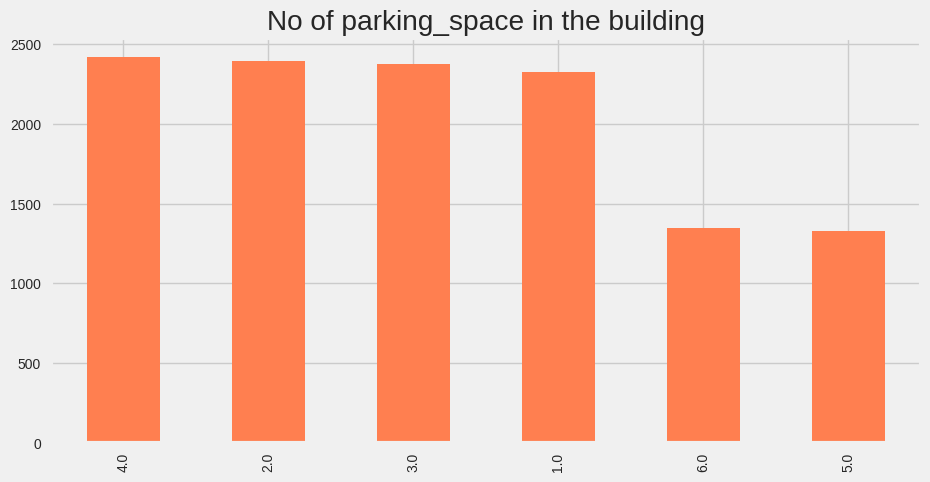

In [37]:
countplot('parking_space')

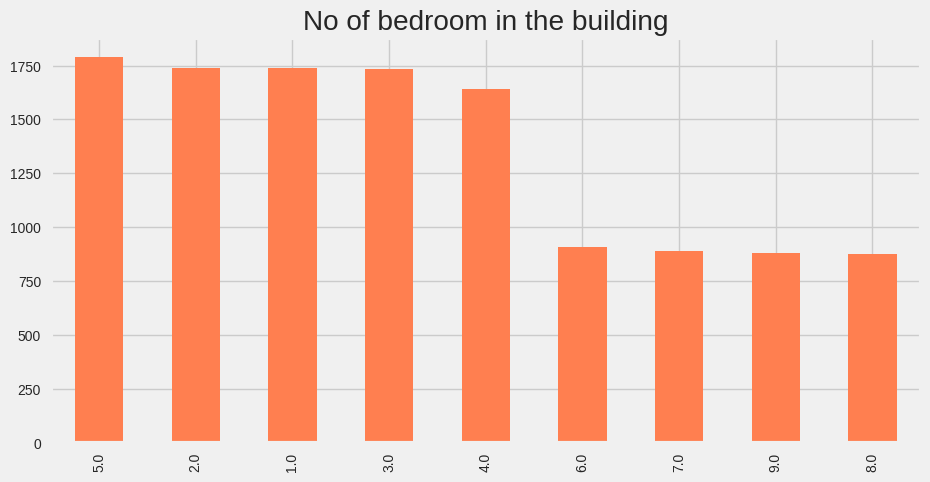

In [38]:
countplot('bedroom')

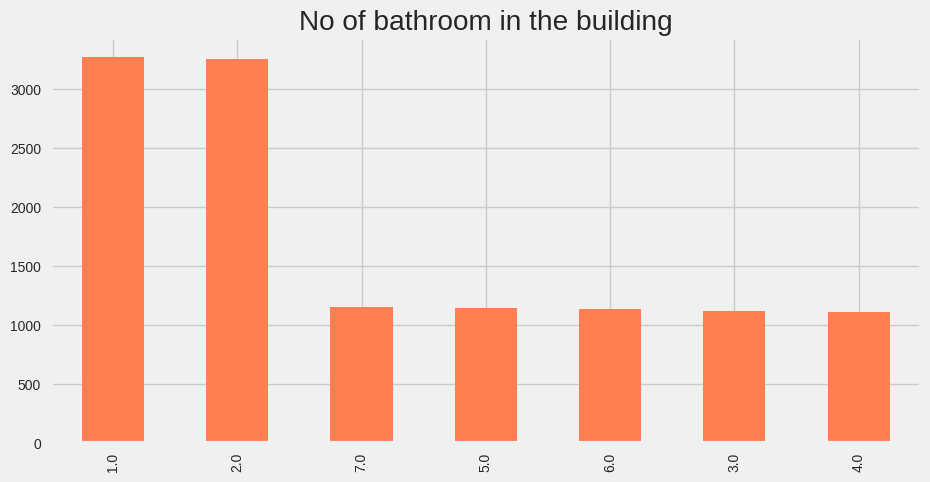

In [39]:
countplot('bathroom')

### Bi variate Analysis

In [49]:
def countplot_bi(main_col, hue_col):
  plt.figure(figsize=(14, 6))
  sns.countplot(x = train[main_col], hue = train[hue_col]).set_title(f'Relationship between {main_col} and {hue_col}')
  plt.show()

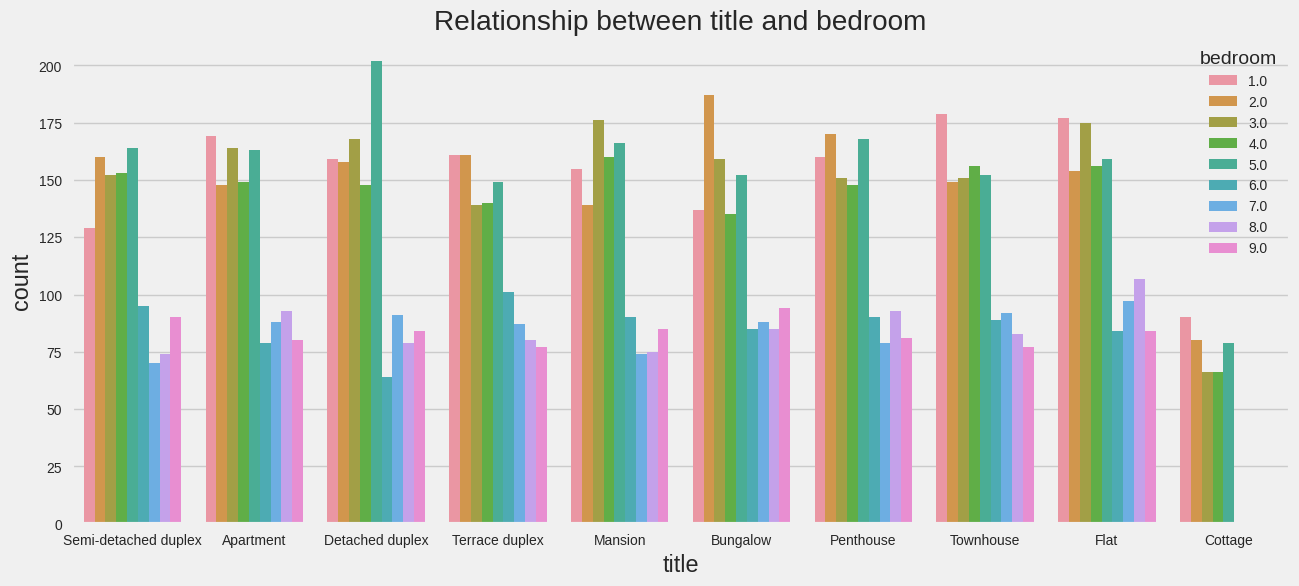

In [50]:
countplot_bi('title', 'bedroom')

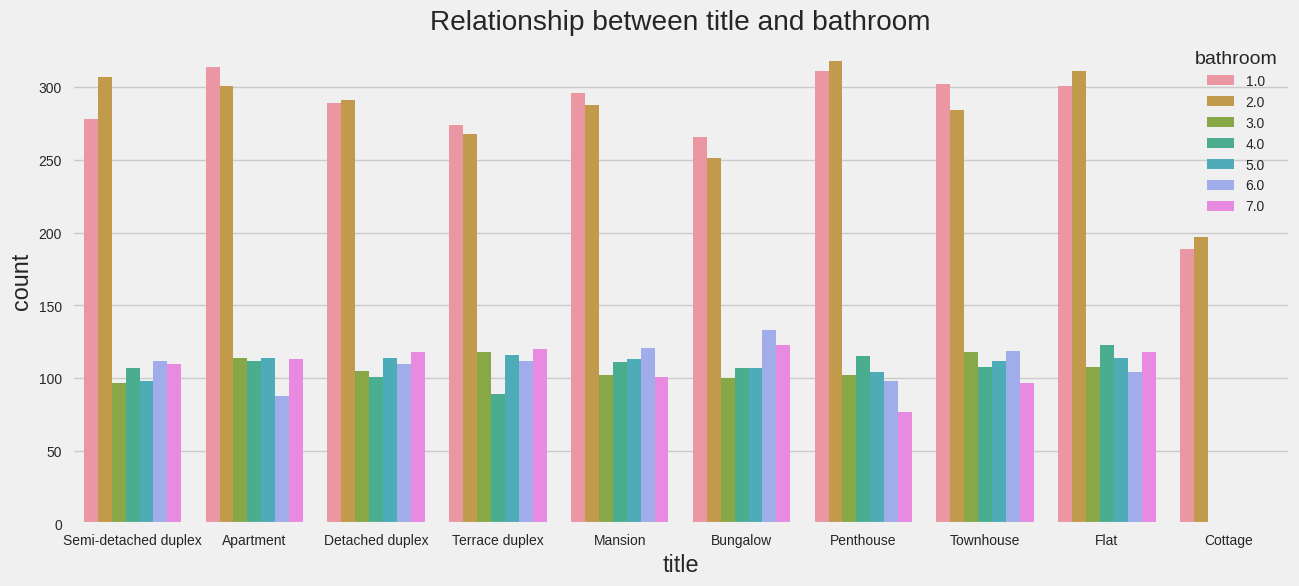

In [51]:
countplot_bi('title', 'bathroom')

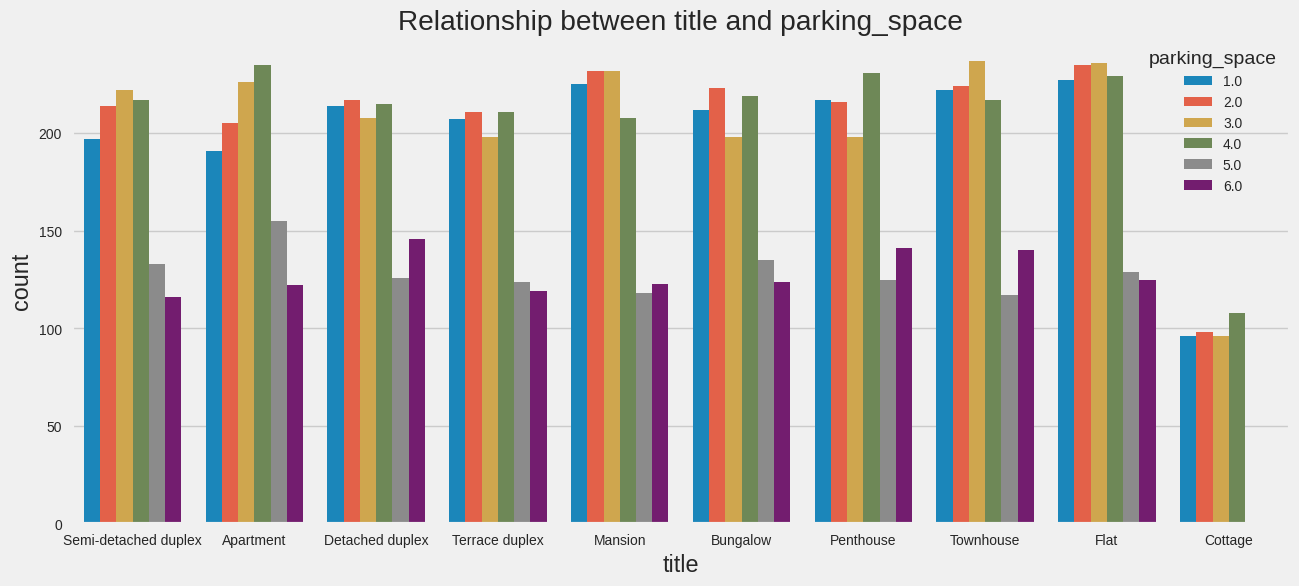

In [52]:
countplot_bi('title', 'parking_space')

In [107]:
train['price'].max()

16568486.16

In [108]:
train['price'].min()

431967.29

In [65]:
print(f"The Most expensive House is found in {train[train['price'] == train['price'].max()]['loc'].unique()}\n")
print(f"The lest expensive House is found in {train[train['price'] == train['price'].min()]['loc'].unique()}")

The Most expensive building is found in ['Lagos']

The lest expensive building is found in ['Gombe']


In [66]:
print(f"The Most expensive House title is {train[train['price'] == train['price'].max()]['title'].unique()}\n")
print(f"The lest expensive House title is {train[train['price'] == train['price'].min()]['title'].unique()}")

The Most expensive House title is ['Mansion']

The lest expensive House title is ['Cottage']


In [71]:
print(f"Houses with {train[train['price'] == train['price'].min()]['bathroom'].unique()} bathrooms are the lest expensive")

Houses with [2.] bathrooms are the lest expensive


In [74]:
print(f"Houses with {train[train['price'] == train['price'].max()]['bedroom'].unique()} bedrooms are the most expensive\n")
print(f"Houses with {train[train['price'] == train['price'].min()]['bedroom'].unique()} bedroom are the lest expensive")

Houses with [5.] bedrooms are the most expensive

Houses with [1.] bedroom are the lest expensive


In [77]:
print(f"Houses with {train[train['price'] == train['price'].max()]['parking_space'].unique()} parking spaces are the most expensive\n")
print(f"Houses with {train[train['price'] == train['price'].min()]['parking_space'].unique()} parking space are the lest expensive")

Houses with [3.] parking spaces are the most expensive

Houses with [1.] parking space are the lest expensive


### Multivariate analysis

<Axes: >

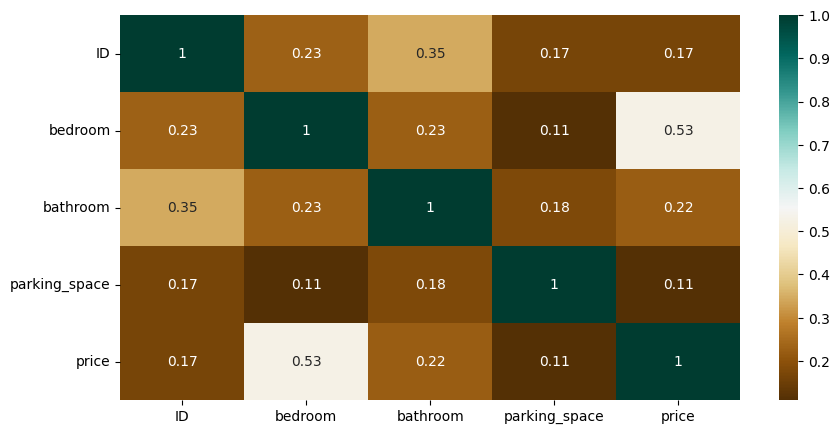

In [ ]:
plt.figure(figsize = (10, 5))
sns.heatmap(train.corr(), cmap ='BrBG', annot = True)

- No correlation

## Preparing the data

In [79]:
df_train = train.copy()

In [80]:
df_test = test.copy()

In [81]:
df_train.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [82]:
test.isnull().sum()

ID               0
loc              0
title            0
bedroom          0
bathroom         0
parking_space    0
dtype: int64

In [83]:
print(df_train['loc'].mode())
print(df_train['title'].mode())
print(df_train['bedroom'].median())
print(df_train['bathroom'].median())
print(df_train['parking_space'].median())

0    Kaduna
Name: loc, dtype: object
0    Flat
Name: title, dtype: object
4.0
2.0
3.0


In [84]:
df_train['loc'] = df_train['loc'].fillna('Edo')
df_train['title'] = df_train['title'].fillna('Flat')
df_train['bedroom'] = df_train['bedroom'].fillna(4)
df_train['bathroom'] = df_train['bathroom'].fillna(2)
df_train['parking_space'] = df_train['parking_space'].fillna(3)

In [85]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in ['loc', 'title']:
  df_train[i] = le.fit_transform(df_train[i])

In [86]:
le2 = LabelEncoder()
for i in ['loc', 'title']:
  df_test[i] = le2.fit_transform(df_test[i])

In [87]:
df_train = df_train.drop('ID', axis = 1)

In [88]:
from imblearn.over_sampling import RandomOverSampler # oversampling the dataset to increase to balance the datasset for the title feature

x = df_train.drop('title', axis=1)
y = df_train['title']

oversampler = RandomOverSampler()

new_x, new_y = oversampler.fit_resample(x, y)

new_df = pd.DataFrame(new_x, columns = x.columns)
new_df['title'] = new_y

new_df.shape

(30940, 6)

## Modelling

In [89]:
x = new_df.drop(['price'], axis = 1)
y = new_df['price']

In [90]:
df_test = df_test.drop('ID', axis = 1)

In [91]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 8)

In [92]:
# from lightgbm import LGBMClassifier
lb = LGBMRegressor()
lb.fit(x_train, y_train)

LGBMRegressor()

In [93]:
import catboost as ctb
ct_mod = ctb.CatBoostRegressor(verbose = False)
ct_mod.fit(x_train, y_train)

In [94]:
import xgboost as xgb
xg_mod = xgb.XGBRegressor()
xg_mod.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [95]:
from sklearn.metrics import r2_score, mean_squared_error

def result(model):
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"The R2 score of the {type(model).__name__} is {r2}")
    print(f"The RMSE score of the {type(model).__name__} is {rmse}")

In [96]:
result(xg_mod)

The R2 score of the XGBRegressor is 0.805902870347831
The RMSE score of the XGBRegressor is 468263.19589781


In [97]:
result(ct_mod)

The R2 score of the CatBoostRegressor is 0.7972658330016662
The RMSE score of the CatBoostRegressor is 478568.3153681222


In [98]:
result(lb)

The R2 score of the LGBMRegressor is 0.799410827051965
The RMSE score of the LGBMRegressor is 476029.87818659813


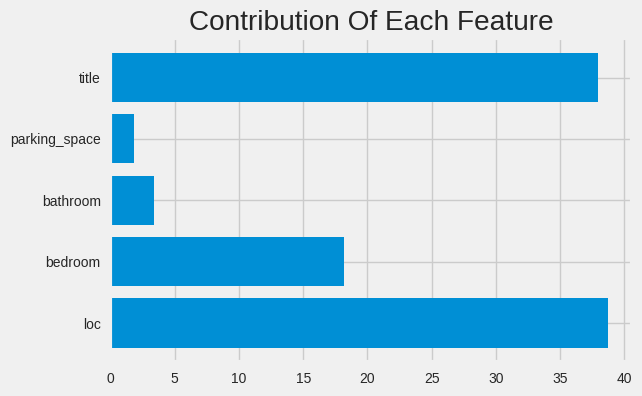

In [103]:
plt.figure(figsize = (6, 4))
plt.barh(x.columns, ct_mod.feature_importances_)
plt.title("Contribution Of Each Feature")
plt.show()

## Parameter Tuning

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 1, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
        'random_seed': 6,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'verbose': False
    }

    ct_model = CatBoostRegressor(**params)
    ct_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=50, verbose=False)
    y_pred = ct_model.predict(x_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return rmse

In [ ]:
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial
print(f'  RMSE: {trial.value:.4f}')
print('  Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
best_params = trial.params
ct_model = CatBoostRegressor(**best_params)
ct_model.fit(x_train, y_train)

- The model didn't improve after the parameter tuning

In [ ]:
df_test_x = df_test[['loc', 'bedroom', 'bathroom', 'parking_space',	'title', 'total_num_add_room', 'bed_bath', 'bath_ps', 'bed_ps']]

In [ ]:
xgb_pred = xg_mod.predict(df_test_x)
ct_pred = ct_model.predict(df_test_x)
lb_pred = lb.predict(df_test_x)

In [ ]:
subfile = subm[['ID']]
subfile['price'] = ct_pred
subfile.to_csv('ct_final.csv', index = False)

In [ ]:
subfile = subm[['ID']]
subfile['price'] = lb_pred
subfile.to_csv('lbdf.csv', index = False)

In [ ]:
subfile = subm[['ID']]
subfile['price'] = xgb_pred
subfile.to_csv('xgbdf.csv', index = False)

- Catboost performed best on the leaderboard